### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BinaryBRSETDataset
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES_PATH = os.path.join(DATASET, 'images/')
LABEL = 'diabetic_retinopathy'
TEST_SIZE = 0.3
UNDERSAMPLE = True

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

BACKBONE = 'retfound'
MODE = 'fine_tune'
backbone_mode = 'eval'

HIDDEN = None # 756
num_classes = 2

BATCH_SIZE = 32
NUM_WORKERS = 2

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 10
learning_rate = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in /home/opc/Retina/BRSET//labels.csv


image_id  patient_id    camera  patient_age comorbidities diabetes_time_y  \
0  img00001           1  Canon CR         48.0     diabetes1              12   
1  img00002           1  Canon CR         48.0     diabetes1              12   
2  img00003           2  Canon CR         18.0     diabetes1               7   
3  img00004           2  Canon CR         18.0     diabetes1               7   
4  img00005           3  Canon CR         22.0     diabetes1              11   

  insuline  patient_sex  exam_eye diabetes  ... vascular_occlusion  \
0      yes            1         1      yes  ...                  0   
1      yes            1         2      yes  ...                  0   
2      yes            2         1      yes  ...                  0   
3      yes            2         2      yes  ...                  0   
4      yes            1         1      yes  ...                  0   

  hypertensive_retinopathy  drusens  hemorrhage  retinal_detachment  \
0                        0        0           0                   0   
1                        0        0           0                   0   
2                        0        0           0                   0   
3                        0        0           0                   0   
4                        0        0           0                   0   

   myopic_fundus  increased_cup_disc  other   quality  normality  
0              0                   1      0  Adequate   abnormal  
1              0                   1      0  Adequate   abnormal  
2              0                   0      0  Adequate     normal  
3              0                   0      0  Adequate     normal  
4              0                   0      0  Adequate     normal  

[5 rows x 35 columns]

Train data shape: (1830, 35)
Test data shape: (4880, 35)


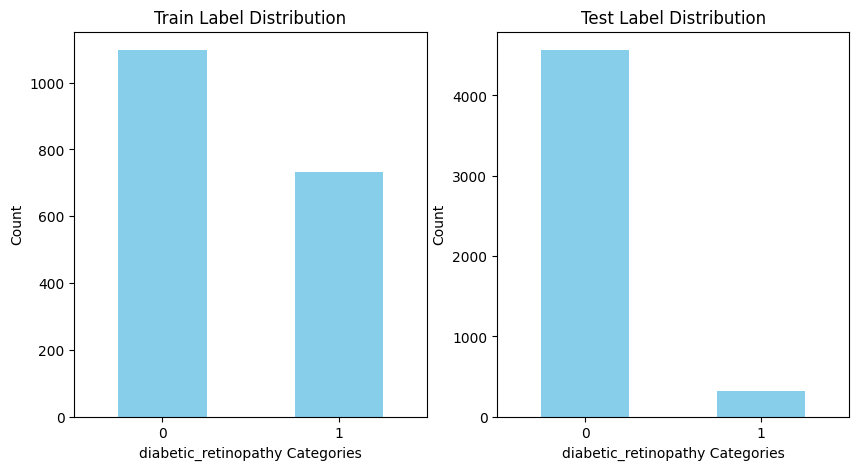

Getting validation set...
Train data shape: (4148, 35)
Test data shape: (732, 35)


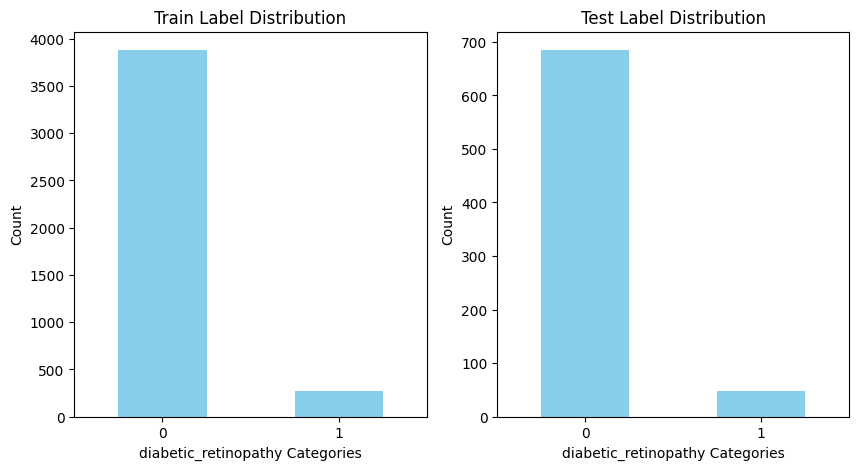

In [4]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=UNDERSAMPLE, undersample_ratio=1.5)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.15)

### Dataloaders

In [5]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [6]:
# Create the custom dataset
train_dataset = BinaryBRSETDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_train,
    shape=SHAPE,
    transform=train_transforms,
    label_col=LABEL
)

test_dataset = BinaryBRSETDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_test,
    shape=SHAPE,
    transform=test_transform,
    label_col=LABEL
)

val_dataset = BinaryBRSETDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_val,
    shape=SHAPE,
    transform=test_transform,
    label_col=LABEL
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


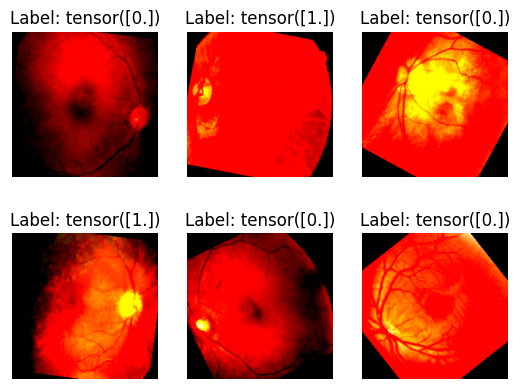

In [7]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [8]:
# Create a DataLoader to generate embeddings
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE, weights='Weights/RETFound_cfp_weights.pth')
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [9]:
if LOSS == 'focal_loss':
    criterion = BinaryFocalLoss(alpha=1, gamma=2)  # Focal Loss
else:
    criterion = nn.BCEWithLogitsLoss()  #nn.BCELoss()  # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

100%|██████████| 58/58 [01:14<00:00,  1.28s/it]


Epoch 1, Training Loss: 0.19968125121346836


100%|██████████| 23/23 [00:25<00:00,  1.10s/it]


Epoch 1, Validation Loss: 0.22917952291343524, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.24s/it]


Epoch 2, Training Loss: 0.1528735221203031


100%|██████████| 23/23 [00:26<00:00,  1.13s/it]


Epoch 2, Validation Loss: 0.05794474417748659, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 3, Training Loss: 0.13419577164639687


100%|██████████| 23/23 [00:25<00:00,  1.09s/it]


Epoch 3, Validation Loss: 0.12865948191155557, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 4, Training Loss: 0.11921829043020463


100%|██████████| 23/23 [00:25<00:00,  1.12s/it]


Epoch 4, Validation Loss: 0.12417049965132838, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 5, Training Loss: 0.11398091286035447


100%|██████████| 23/23 [00:26<00:00,  1.14s/it]


Epoch 5, Validation Loss: 0.11595470199118489, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 6, Training Loss: 0.10428999987398756


100%|██████████| 23/23 [00:25<00:00,  1.12s/it]


Epoch 6, Validation Loss: 0.1121238632046658, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 7, Training Loss: 0.10157927016502824


100%|██████████| 23/23 [00:26<00:00,  1.13s/it]


Epoch 7, Validation Loss: 0.13577241450548172, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.24s/it]


Epoch 8, Training Loss: 0.0927044412699239


100%|██████████| 23/23 [00:25<00:00,  1.12s/it]


Epoch 8, Validation Loss: 0.086358943225249, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 9, Training Loss: 0.09121820497615583


100%|██████████| 23/23 [00:25<00:00,  1.11s/it]


Epoch 9, Validation Loss: 0.1141355452330216, F1 Score: 1.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch 10, Training Loss: 0.09391240435170717


100%|██████████| 23/23 [00:25<00:00,  1.13s/it]


Epoch 10, Validation Loss: 0.036307910659714886, F1 Score: 1.0


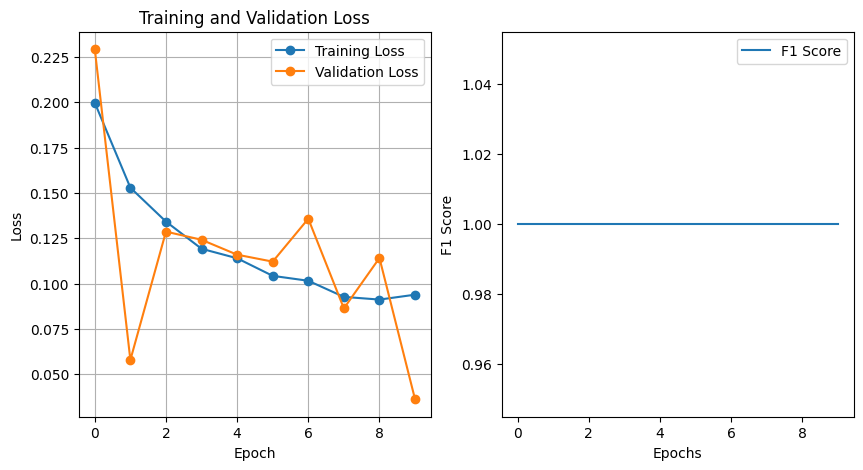

Training finished.


In [10]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=False, device=device)

### Test

100%|██████████| 130/130 [02:16<00:00,  1.05s/it]


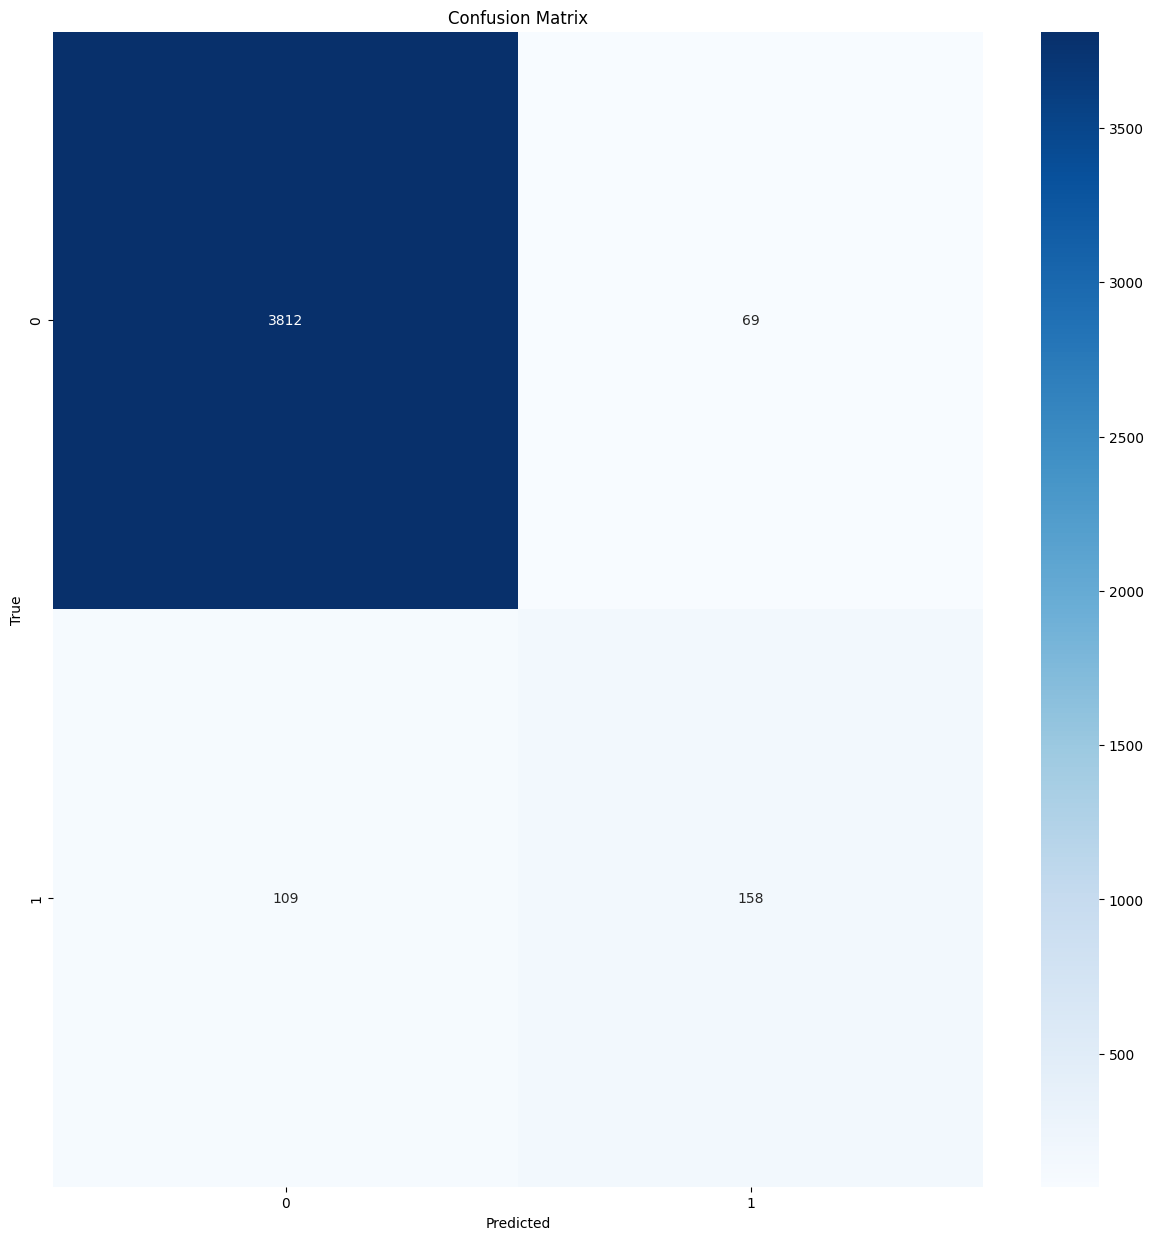

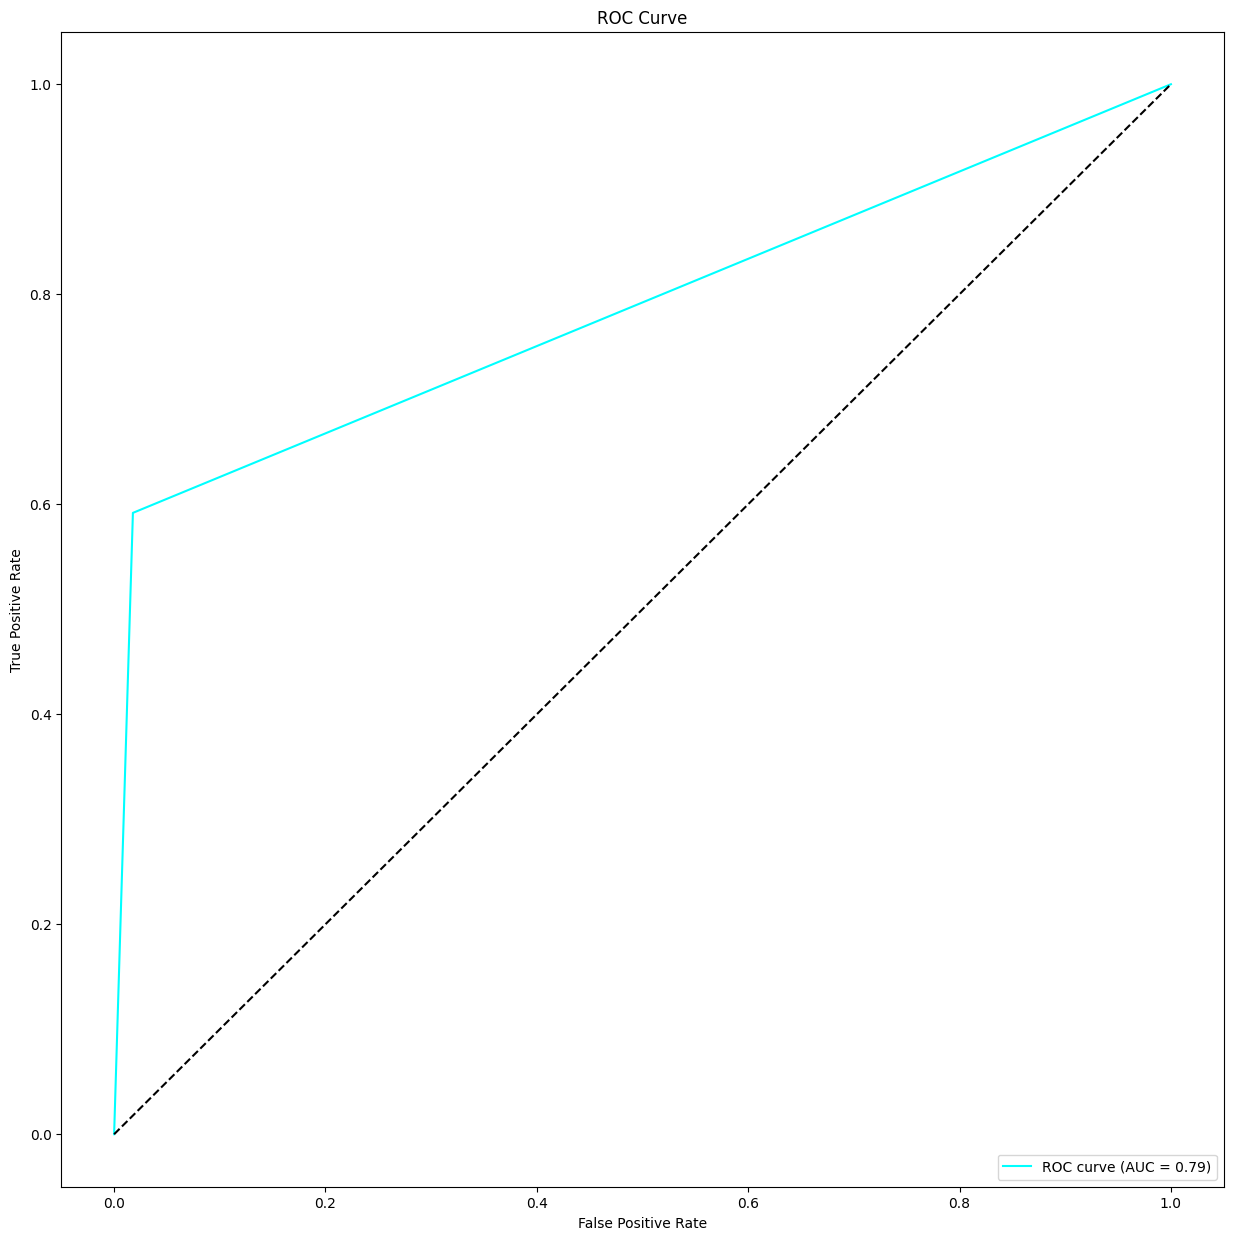

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      3881
         1.0       0.70      0.59      0.64       267

    accuracy                           0.96      4148
   macro avg       0.83      0.79      0.81      4148
weighted avg       0.95      0.96      0.96      4148

##################################################  Saliency Maps  ##################################################

Class 0:


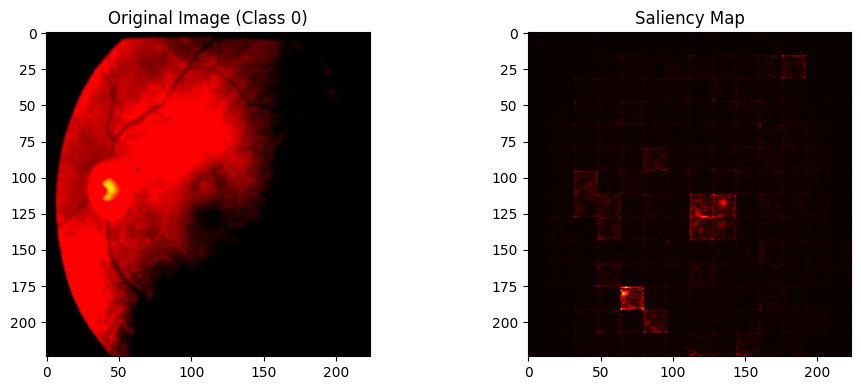

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


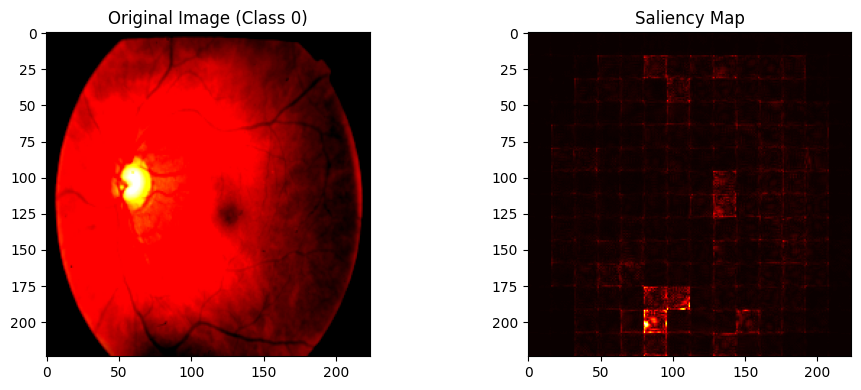

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


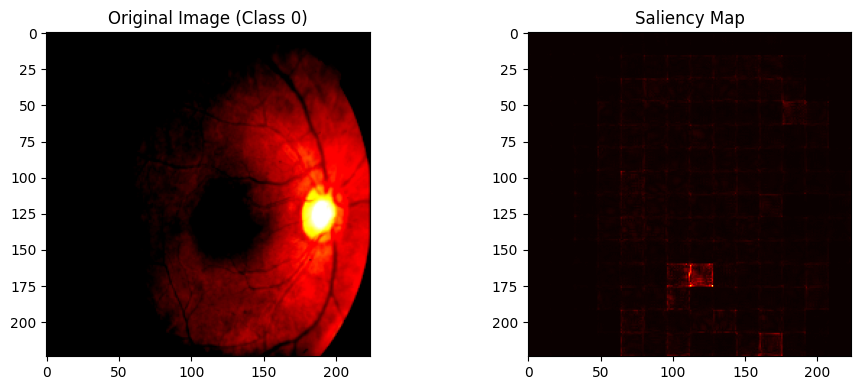

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


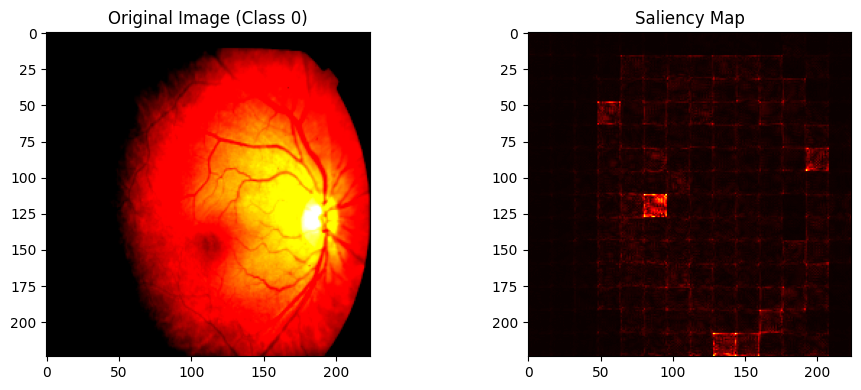

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


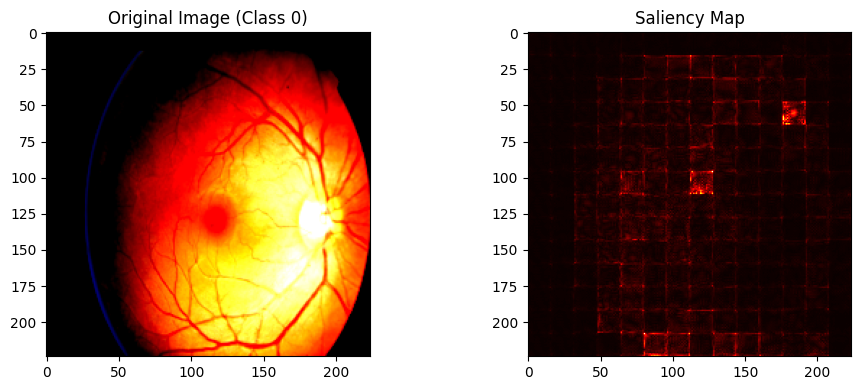

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


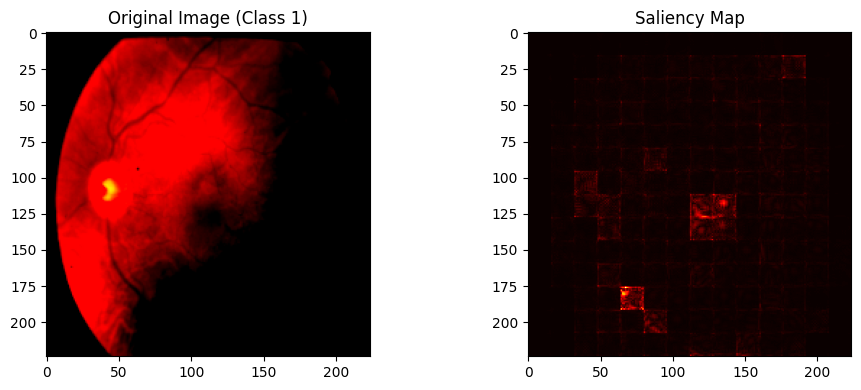

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


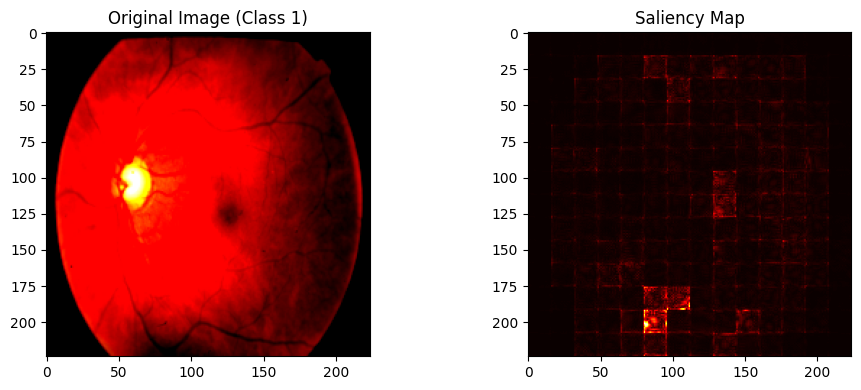

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


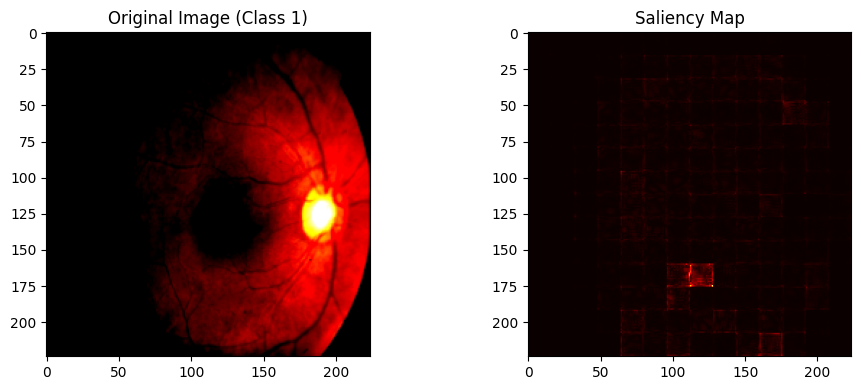

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


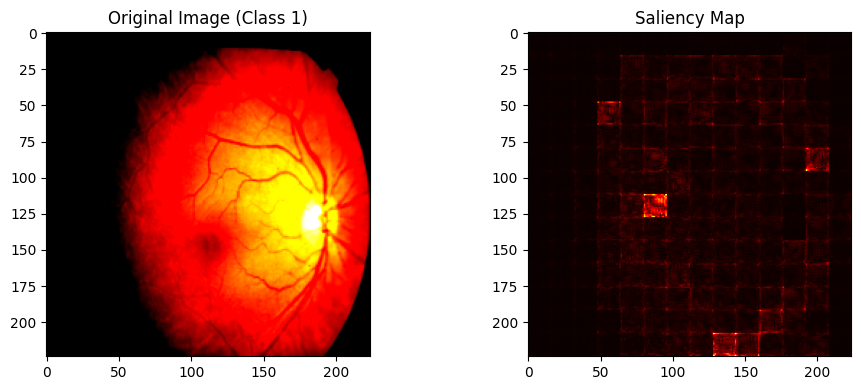

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


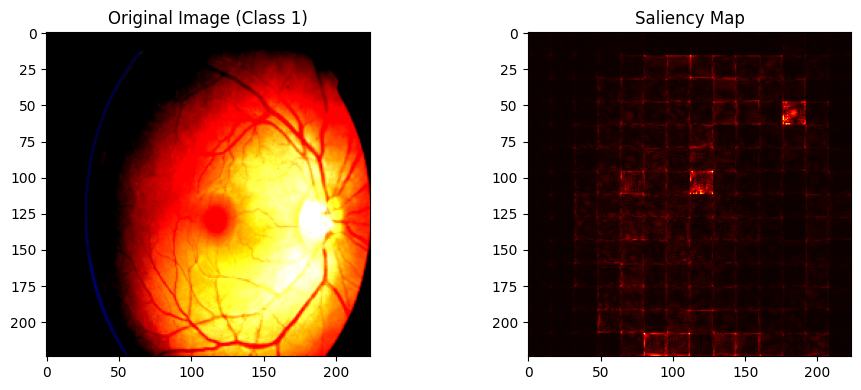

In [11]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [12]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BinaryBRSETDataset(
    folder_path=IMAGES_PATH,
    dataframe=adequate_df,
    shape=SHAPE,
    transform=test_transform,
    label_col=LABEL
)

inadequate_dataset = BinaryBRSETDataset(
    folder_path=IMAGES_PATH,
    dataframe=inadequate_df,
    shape=SHAPE,
    transform=test_transform,
    label_col=LABEL
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 114/114 [01:59<00:00,  1.05s/it]


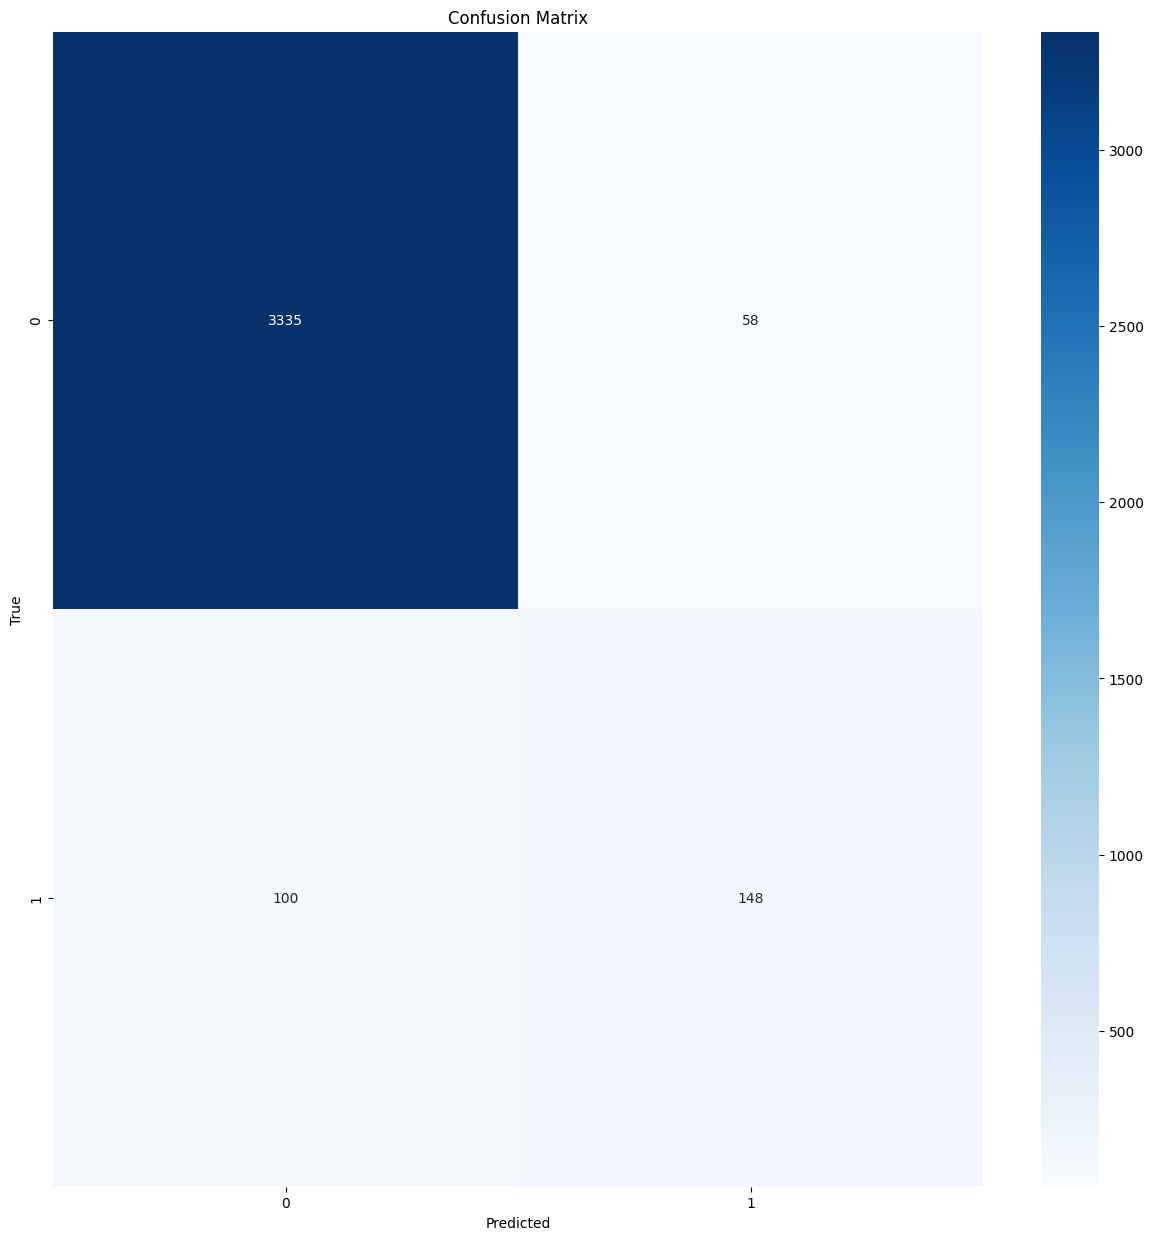

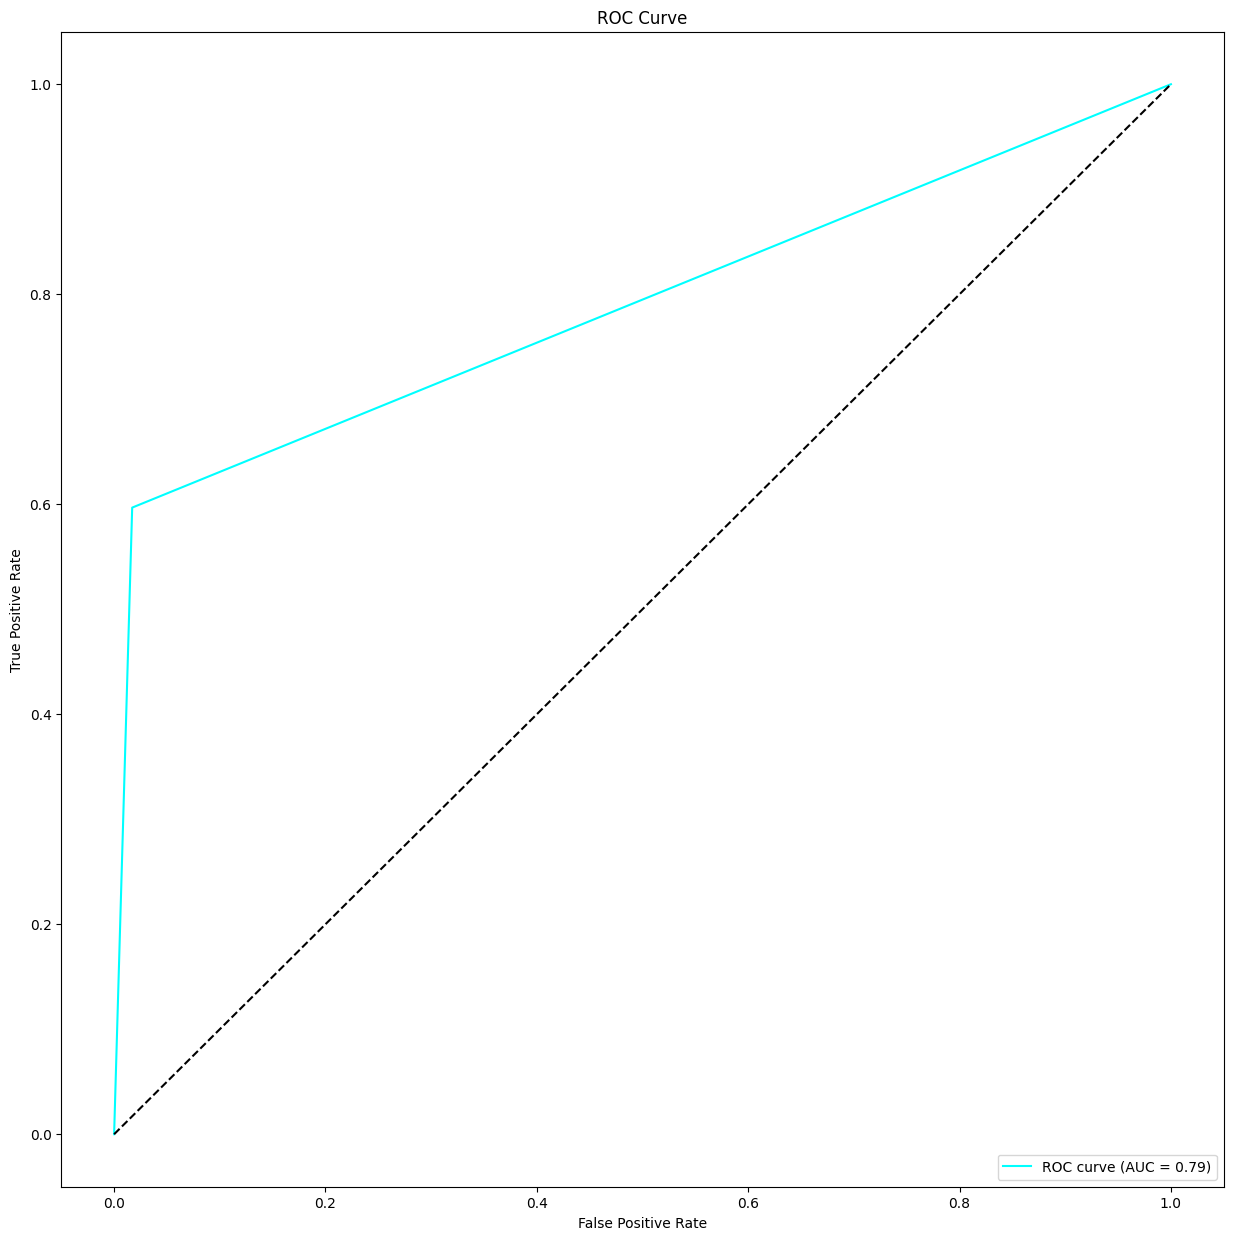

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      3393
         1.0       0.72      0.60      0.65       248

    accuracy                           0.96      3641
   macro avg       0.84      0.79      0.81      3641
weighted avg       0.95      0.96      0.95      3641

##################################################  Saliency Maps  ##################################################

Class 0:


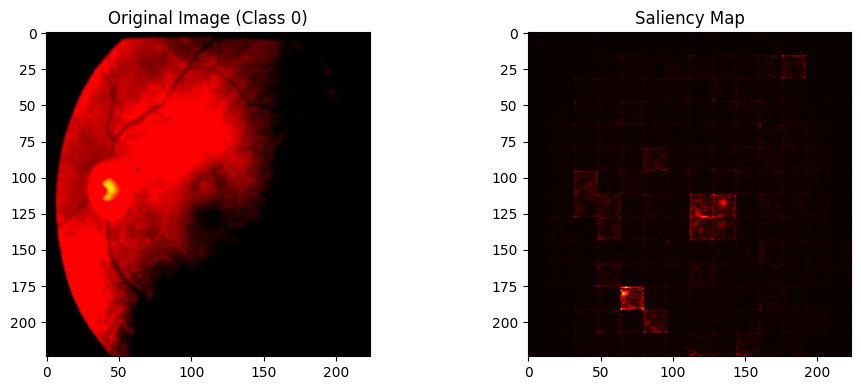

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


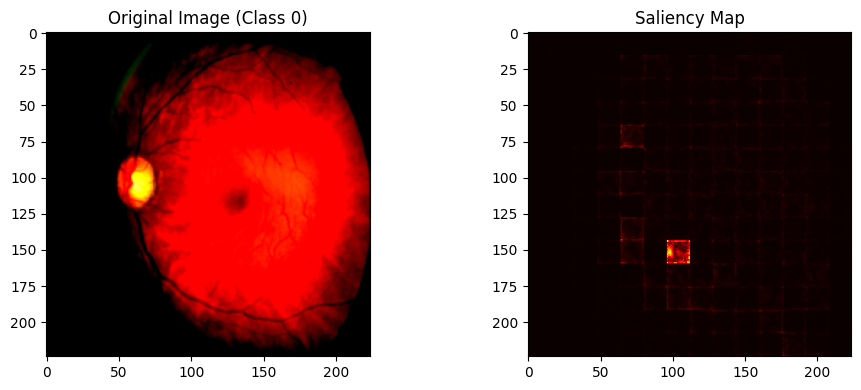

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


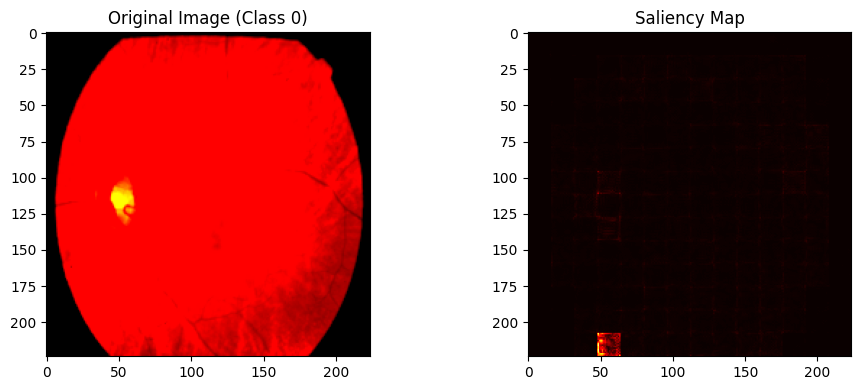

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


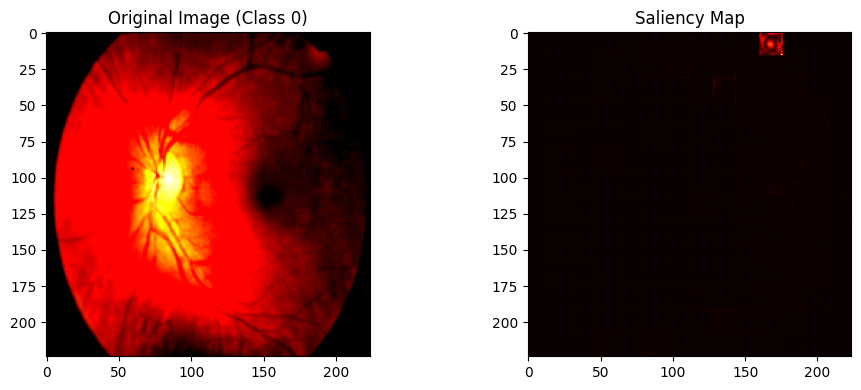

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


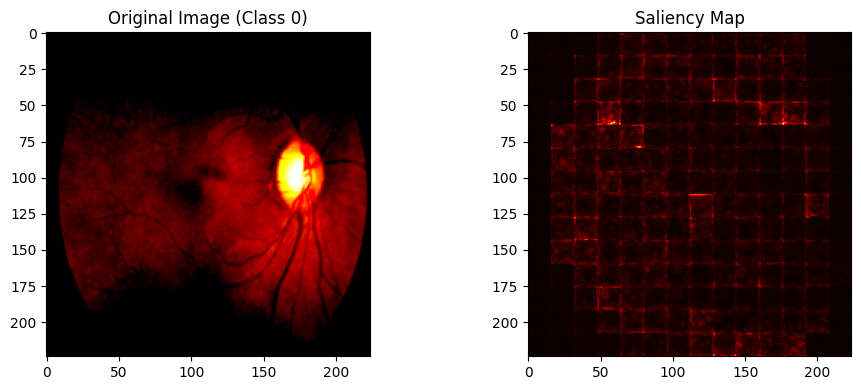

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


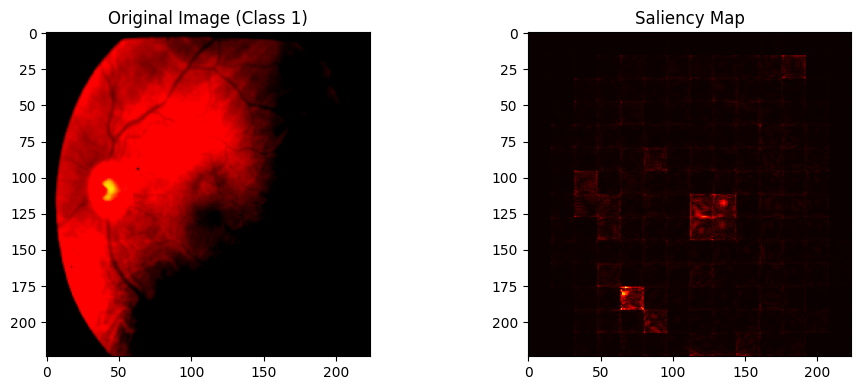

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


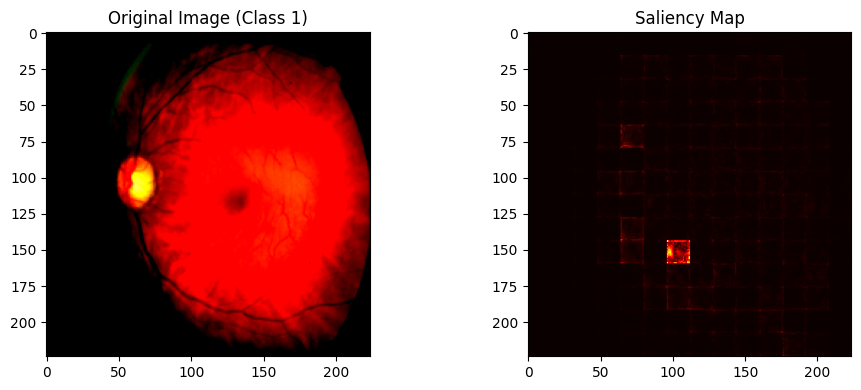

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


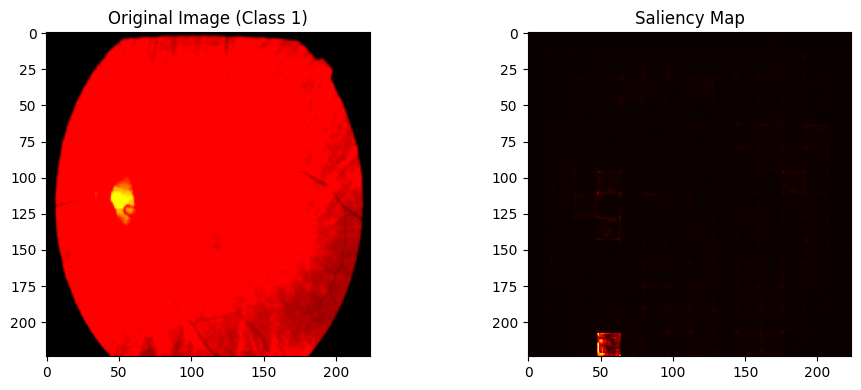

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


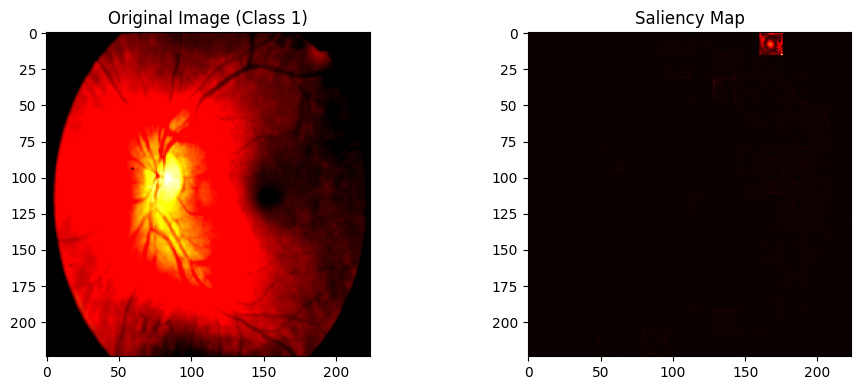

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


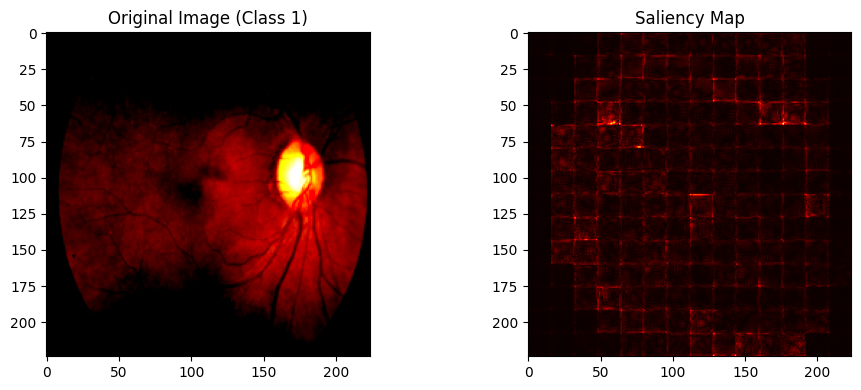

In [13]:
test(model, adequate_dataloader, saliency=True, device=device)

#### Inadequate image quality

100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


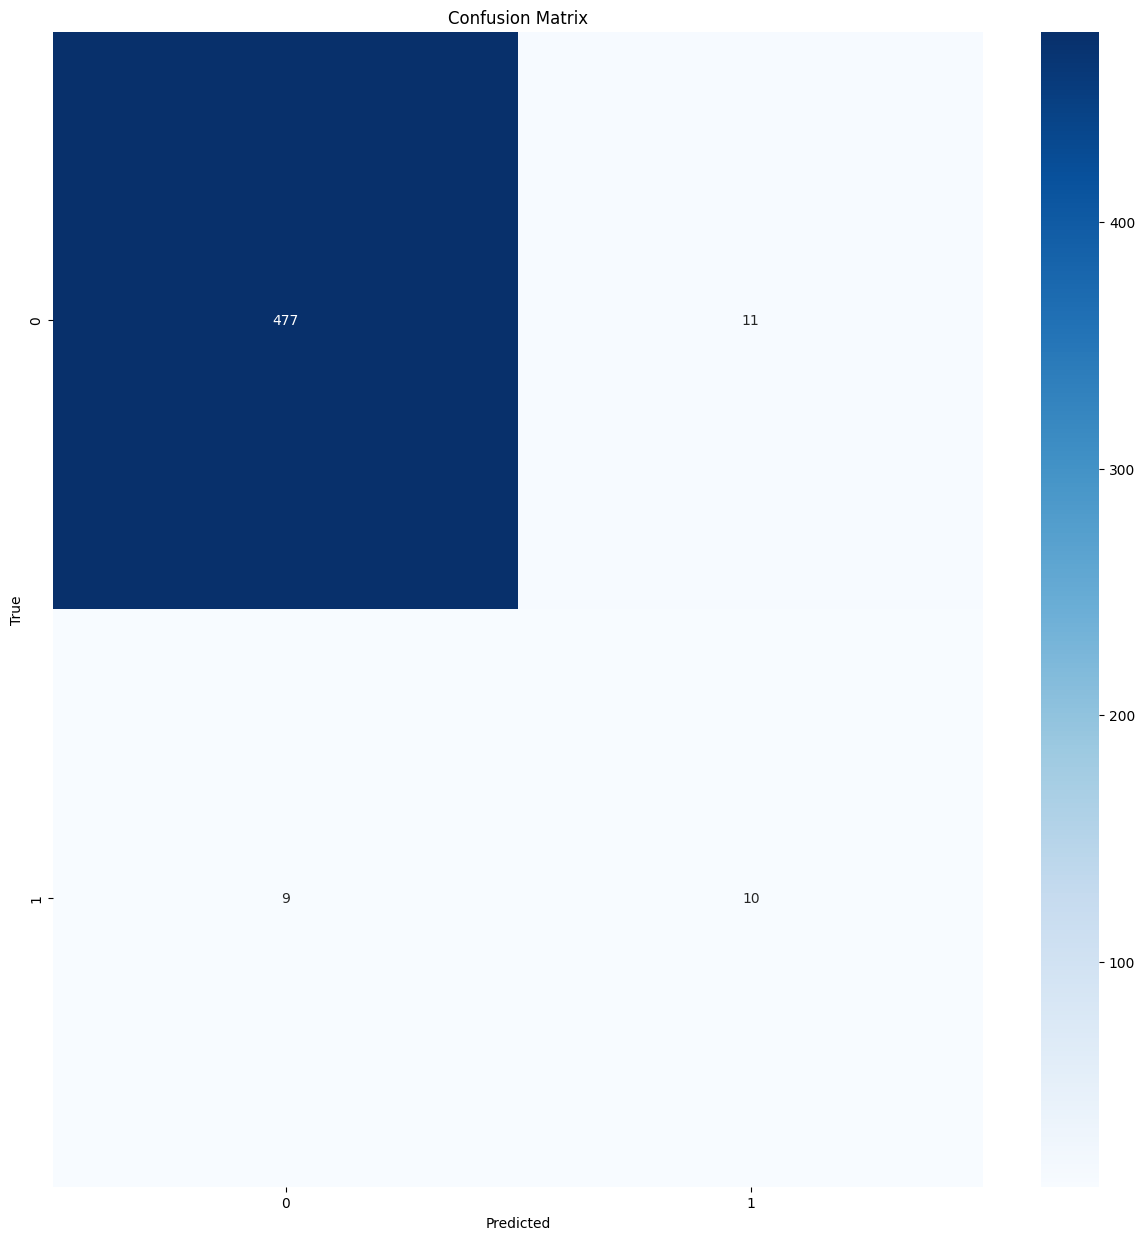

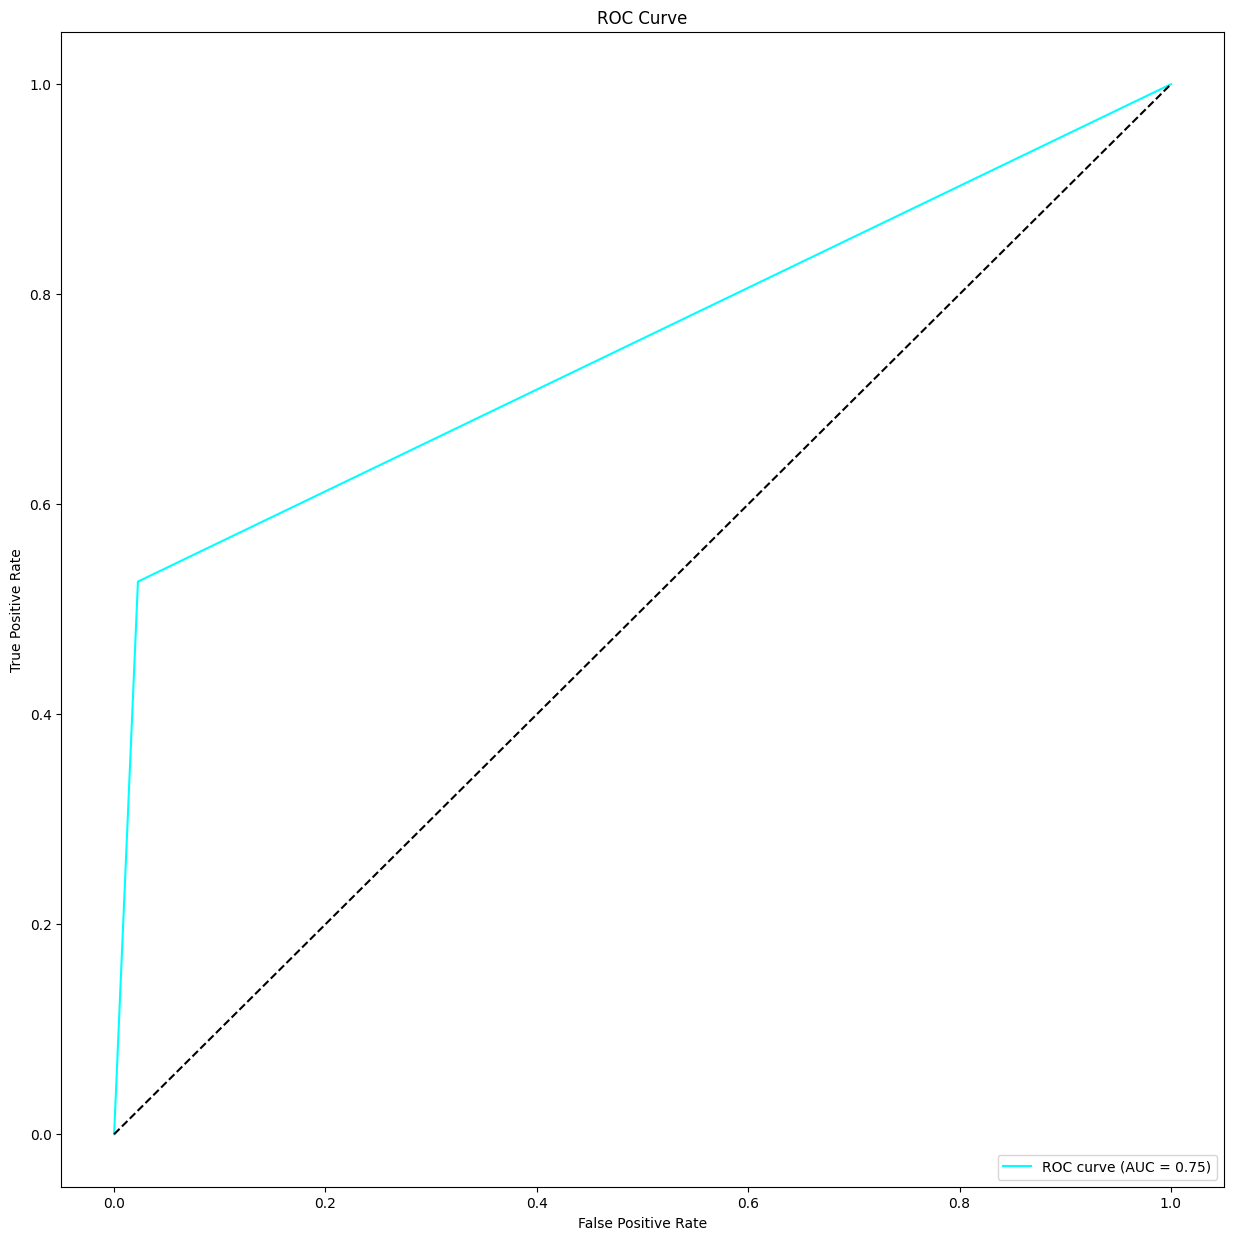

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       488
         1.0       0.48      0.53      0.50        19

    accuracy                           0.96       507
   macro avg       0.73      0.75      0.74       507
weighted avg       0.96      0.96      0.96       507

##################################################  Saliency Maps  ##################################################

Class 0:


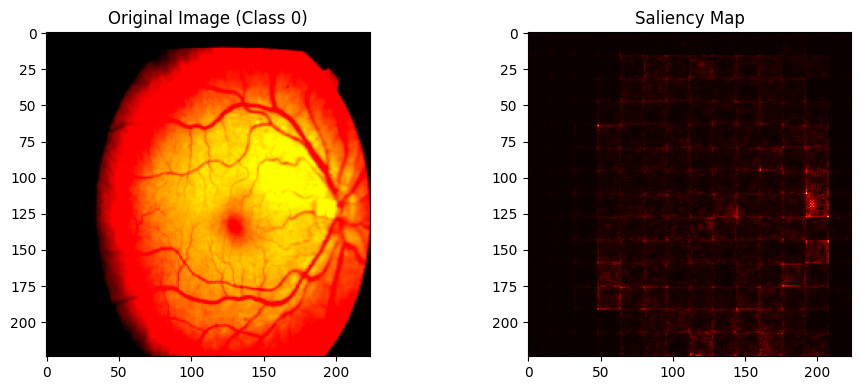

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


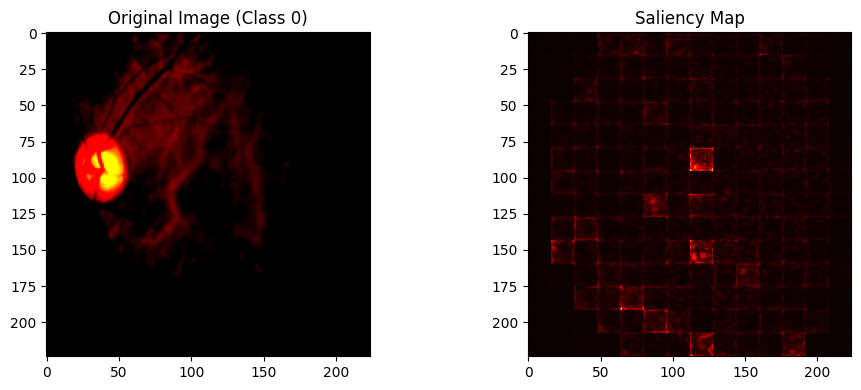

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


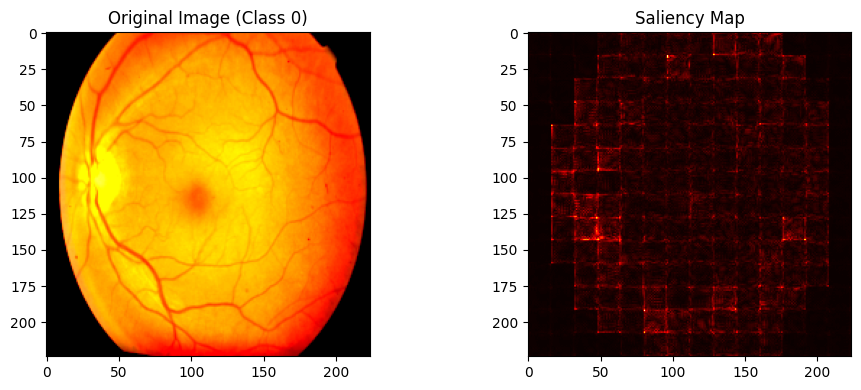

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


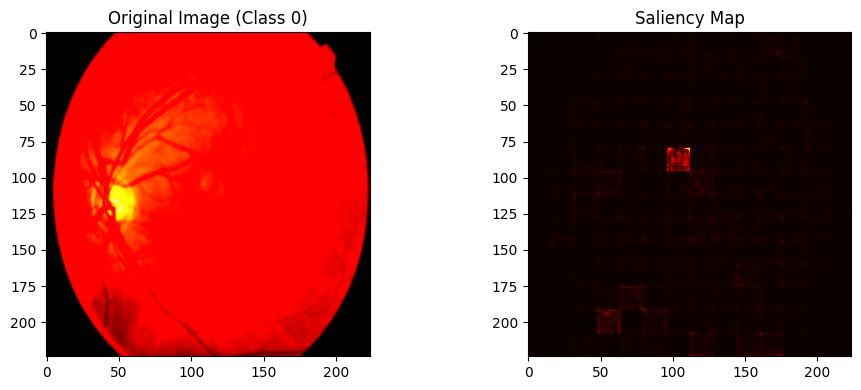

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


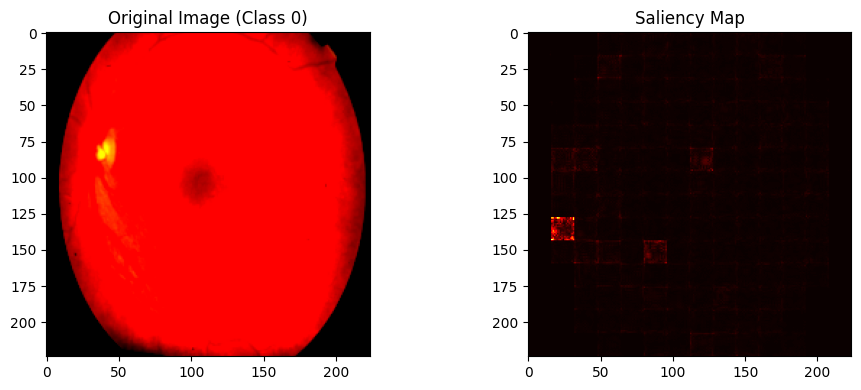

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


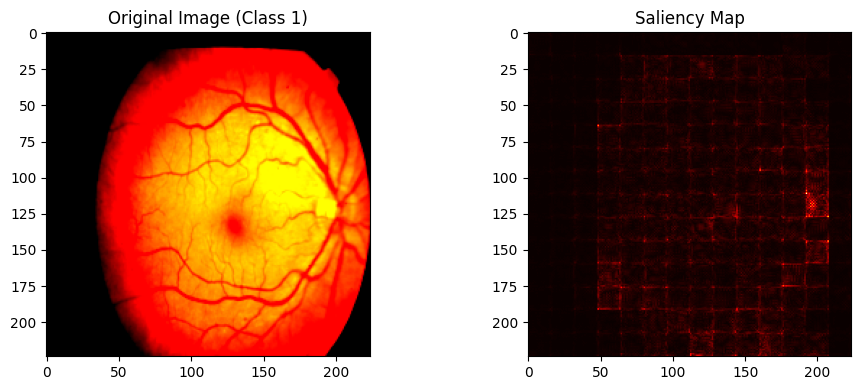

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


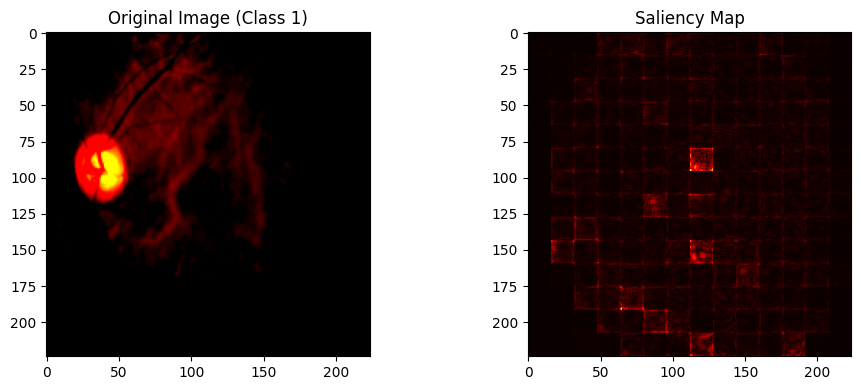

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


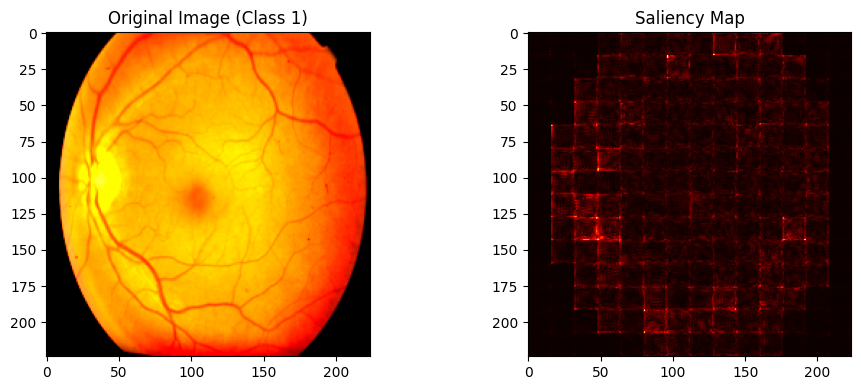

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


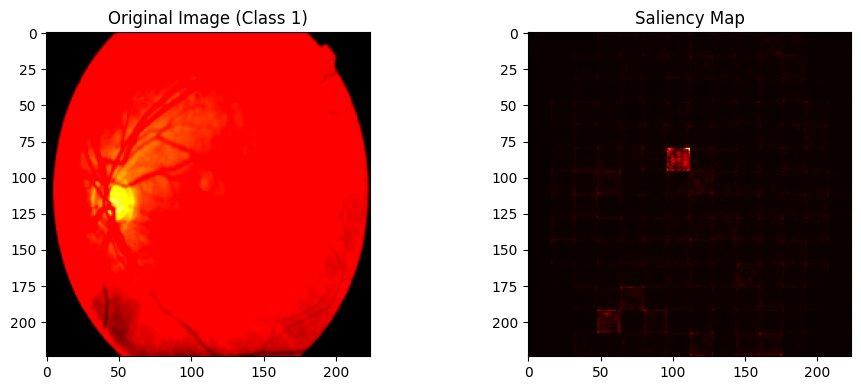

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


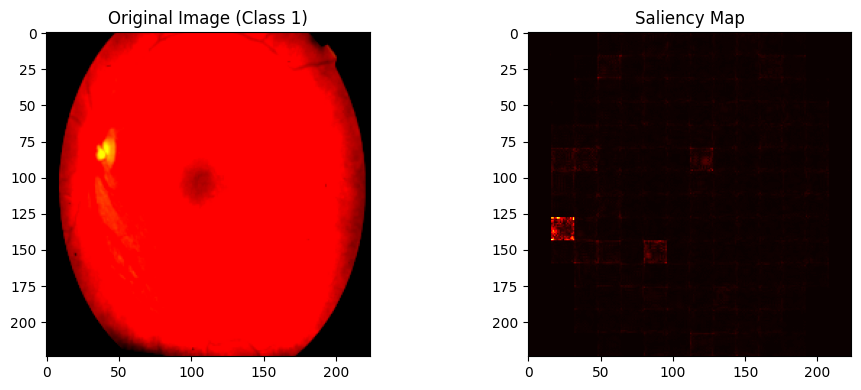

In [14]:
test(model, inadequate_dataloader, saliency=True, device=device)